# Serial CPU - Python Standard

# Metropolis Algorithm ($h=0$)
## Algorithm
1. Choose an initial state $S(0) = (S_1,\ldots,S_N)$
2. Choose an $i$ (randomly or sequentially) and calculate $\Delta E=-2S_ih_i$
3. If $\Delta E\geq 0$, then flip the spin, $S_i\to -S_i$. If $\Delta E< 0$, draw a uniformly distributed random number $r \in [0,1]$. If $r < e^{\Delta E/kbT}$, flip the spin, $S_i\to -S_i$, otherwise take the old configuration into account once more.
4. Iterate 2 and 3.



$$H(S)=-JS_i\sum_{j\in N(i)}S_j-hS_i+remainder$$
$$\Delta E=-2S_i\left(J\sum_{j\in N(i)}S_j+h\right)=-2S_ih_i$$

## Modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Functions

In [2]:
#----------------------------------------------------------------------
##  BLOCK OF FUNCTIONS USED IN THE MAIN CODE
#----------------------------------------------------------------------
def initial_state(N, M):
    """
    Create an array of size (N, M) with random values of -1, +1
    
    Parameters:
    -----------
    N: int
        no. of rows
    M: int
        no. of columns
        
    Returns:
    ---------
    array
        The lattice containing random spins
    """
    
    state = np.random.choice(np.array([-1,1]),size=(N,M))
    return state


def mc_move(lattice, inv_temp, J, h):    
    """
    Perform 1 Monte Carlo sweep using the Metropolis algorithm
    
    Parameters:
    -----------
    lattice: array
        The lattice to perform an MC sweep on
    inv_temp: float
        The inverse temperature of the system
    J: float
        Interaction constant
    h: float
        External magnetic field
        
    Returns
    -------
    array
        The lattice after performing 1 MC sweep
    """
    
    n = lattice.shape[0]
    m = lattice.shape[1]
    for i in range(n):
        for j in range(m):
            # Periodicity for neighbors out of index
            ipp = (i + 1) if (i + 1) < n else 0
            jpp = (j + 1) if (j + 1) < m else 0
            inn = (i - 1) if (i - 1) >= 0 else (n - 1)
            jnn = (j - 1) if (j - 1) >= 0 else (m - 1)  
            
            # Calculate neighbors
            nb = lattice[ipp,j] + lattice[i,jpp] + lattice[inn,j] + lattice[i,jnn]
            
            # Compute energy difference
            spin =  lattice[i, j]
            delta_E = -2*spin*(J*nb + h)
            
            # Conditions for flipping:
            if delta_E >= 0:
                lattice[i, j] = -spin
            elif np.random.rand() < np.exp(delta_E*inv_temp):
                lattice[i, j] = -spin
    return lattice


def calc_energy(lattice, J, h):
    """"
    Calculates the total internal energy of a given configuration
    
    Parameters:
    -----------
    lattice: array
        The lattice is the configuration to be calculated
    J: float
        Interaction constant
    h: float
        External magnetic field
        
    Returns
    -------
    float
        The calculated total energy of the lattice
    
    """
    n = lattice.shape[0]
    m = lattice.shape[1]
    
    energy = 0
    for i in range(n):
        for j in range(m):
            # For periodicty and index
            ipp = (i + 1) if (i + 1) < n else 0
            jpp = (j + 1) if (j + 1) < m else 0
            inn = (i - 1) if (i - 1) >= 0 else (n - 1)
            jnn = (j - 1) if (j - 1) >= 0 else (m - 1)
            
            spin = lattice[i,j]
            nb = lattice[ipp, j] + lattice[i,jpp] + lattice[inn, j] + lattice[i,jnn]
            energy += ((-J*nb*spin)-(h*nb))
    return energy/2.


def calc_mag(lattice):
    """
    Return the total magnetization of a given configuration
    
    Parameters:
    -----------
    lattice: array
        The lattice is the configuration to be calculated
        
    Returns
    --------
    int
        The total magnetization of the lattice
    """

    mag = np.sum(lattice, dtype=np.int64)
    return mag

def plot_ising(lattice, colorbar=True):
    plt.imshow(lattice, cmap='gray', vmin=-1, vmax=1) 
    if colorbar == True:
        plt.colorbar()

## Simulation

In [11]:
######### Set the Variables ############

# Size of the lattice:
lattice_n = 64
lattice_m = 64

seed_no = 1234 # Seed no.

# No. of Steps
eq_steps = 100 # equlibration steps
mc_steps = 1000 # monte carlo steps

# Parameters
J=1 # Interaction constant
h=0 # external magnetic field

# For calculation of the mean of observables:
n1 = 1.0/(mc_steps*lattice_n*lattice_m)
n2 = 1.0/(mc_steps*mc_steps*lattice_n*lattice_m)

np.random.seed(seed_no) # Set the seed no.

# Temperatures
temp = 2.0
inv_temp = 1/temp # inverse temperature
inv_temp_sq = inv_temp*inv_temp # squared inverse temperature

######### Start of the Simulation ############

# Create a lattice
lattice = initial_state(lattice_n, lattice_m)
initial_lattice = lattice.copy()

# Equilibration
for i in range(eq_steps):
    mc_move(lattice, inv_temp, J, h)

E1 = M1 = E2 = M2 = 0 # For the observables
# Start of calculation
for i in range(mc_steps):
    mc_move(lattice, inv_temp, J, h)
    
    # Calculation of observables
    Ene = calc_energy(lattice, J, h)
    Mag = calc_mag(lattice)
    
    E1 += Ene
    M1 += Mag
    M2 += Mag*Mag 
    E2 += Ene*Ene

E = n1*E1 # Internal Energy
M = n1*M1 # Magnetization
C = (n1*E2 - n2*E1*E1)*inv_temp_sq # Specific Heat
X = (n1*M2 - n2*M1*M1)*inv_temp # Magnetic Susceptibility

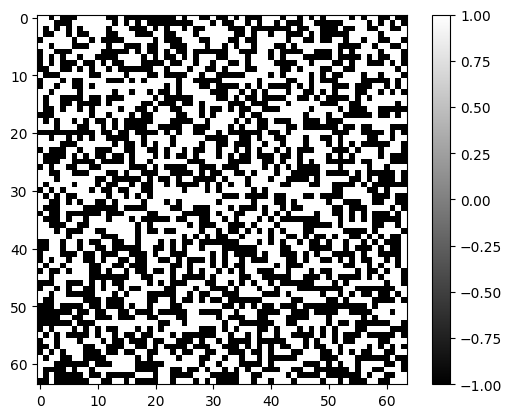

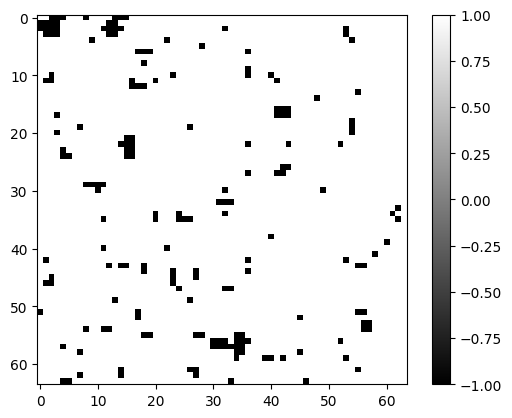

In [12]:
plot_ising(initial_lattice)
plt.show()
plot_ising(lattice)
plt.show()

In [ ]:
file_name = 'native_serial_cpu_data_low_lattice.csv'

with open(file_name, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["nGPUs", "temperature", "seed", "warmup_iter", "trial_iter", "lattice_dim", 
                     "elapsed_time", "updates_per_ns", "avg_mag", "inter_const", "mag_field"])

    file.close()